# Flight Delay Status Classification

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
import pyspark.ml.feature as ftr
import pyspark.ml as ml
 
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline

### Data Loading and Initial Exploration

In [3]:
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()

In [4]:
flight_path = 'gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2018-2022.parquet'
airport_path = 'gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Airports'

flight = spark.read.parquet(flight_path)
airport = spark.read.parquet(airport_path)

In [5]:
flight.printSchema()
airport.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Mar

In [6]:
print('Number of flight records loaded: ' + f'{flight.count():,}')
print('Number of airport records loaded: ' + f'{airport.count():,}')

Number of flight records loaded: 29,193,782
Number of airport records loaded: 13,386


In [11]:
yearly_counts = flight.groupBy("Year").agg(F.count("*").alias("Count of Records")).orderBy("Year")

yearly_counts.show()

+----+----------------+
|Year|Count of Records|
+----+----------------+
|2018|         5689512|
|2019|         8091684|
|2020|         5022397|
|2021|         6311871|
|2022|         4078318|
+----+----------------+



In [7]:
# Filter US airport only 
def airport_transform(dataframe):
  return (
    dataframe
    .filter("AIRPORT_COUNTRY_CODE_ISO = 'US'")
    .dropDuplicates(['AIRPORT'])
    )

In [8]:
airport = airport_transform(airport)
airport.show(5)

23/11/26 20:26:22 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+-------+--------------------+------------------------------+-------------------+-----------+--------------------+------------------------+------------------+------------------+------------------+------------------+--------------+-----------------------------+-----------------------+---------------+-----------+--------------+-----------+-----------+-----------+-----------+--------------+-----------+-----------+-------------+------------------------+------------------+-----------------+-----------------+-----------------+----+
|AIRPORT_SEQ_ID|AIRPORT_ID|AIRPORT|DISPLAY_AIRPORT_NAME|DISPLAY_AIRPORT_CITY_NAME_FULL|AIRPORT_WAC_SEQ_ID2|AIRPORT_WAC|AIRPORT_COUNTRY_NAME|AIRPORT_COUNTRY_CODE_ISO|AIRPORT_STATE_NAME|AIRPORT_STATE_CODE|AIRPORT_STATE_FIPS|CITY_MARKET_SEQ_ID|CITY_MARKET_ID|DISPLAY_CITY_MARKET_NAME_FULL|CITY_MARKET_WAC_SEQ_ID2|CITY_MARKET_WAC|LAT_DEGREES|LAT_HEMISPHERE|LAT_MINUTES|LAT_SECONDS|   LATITUDE|LON_DEGREES|LON_HEMISPHERE|LON_MINUTES|LON_SECONDS|  

In [9]:
# Keep airports that co-exist in the airline dataset
flight.createOrReplaceTempView('flight')
airport.createOrReplaceTempView('airport')

filtered_airport = spark.sql(
  """
  SELECT * 
  FROM airport 
  WHERE 
    AIRPORT IN (
      SELECT DISTINCT ORIGIN FROM flight AS airline_subquery
      UNION
      SELECT DISTINCT DEST FROM flight AS airline_subquery
    )
  """
)
airport = spark.read.option("header", "true").parquet("gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Flight Delay Status Classification/filtered_airport")

airport.createOrReplaceTempView('airport')

print('Number of airports that co-exist in the airline dataset: ' + f'{airport.count():,}')

Number of airports that co-exist in the airline dataset: 387


In [10]:
def flight_transform(dataframe):
    selected_col = ["Year", "Quarter", "Month", "DayofMonth", "DayOfWeek", "FlightDate",
                    "Operating_Airline", "Tail_Number", "Flight_Number_Operating_Airline", 
                    "Origin", "OriginCityName", "OriginState", "Dest", "DestCityName", 
                    "DestState", "CRSDepTime", "DepTime", "DepDelayMinutes", "DepTimeBlk", 
                    "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrTimeBlk", "Distance", 
                    "DistanceGroup", "DepDel15", "ArrDel15", "OriginAirportID", 
                    "DestAirportID", "PR_ARR_DEL15"]

    # Creating a window partition to extract prior arrival delay
    windowSpec = Window.partitionBy("Tail_Number").orderBy("CRSDepTime")

    return (
        dataframe
        .filter("Cancelled != 1 AND Diverted != 1")
        .withColumn("FlightDate", F.col("FlightDate").cast("date"))
        .withColumn("Flight_Number_Operating_Airline", F.col("Flight_Number_Operating_Airline").cast("string"))
        .withColumn("DepTime", F.col("DepTimeBlk").substr(1, 2).cast("int")) 
        .withColumn("ArrTime", F.col("ArrTimeBlk").substr(1, 2).cast("int"))
        .withColumn("DistanceGroup", F.col("DistanceGroup").cast("string"))
        .withColumn("DepDel15", F.col("DepDel15").cast("string"))
        .withColumn("ArrDel15", F.col("ArrDel15").cast("string"))
        .withColumn("Year", F.col("Year").cast("string"))
        .withColumn("Quarter", F.col("Quarter").cast("string"))
        .withColumn("Month", F.col("Month").cast("string"))
        .withColumn("DayofMonth", F.col("DayofMonth").cast("string"))
        .withColumn("DayofWeek", F.col("DayofWeek").cast("string"))
        .withColumn("PR_ARR_DEL15", F.lag(F.col("ArrDel15"), 1).over(windowSpec).cast("string"))
        .select(selected_col)
    )
cleaned_flight = flight_transform(flight)
cleaned_flight.show(10)

+----+-------+-----+----------+---------+----------+-----------------+-----------+-------------------------------+------+-------------------+-----------+----+------------+---------+----------+-------+---------------+----------+----------+-------+---------------+----------+--------+-------------+--------+--------+---------------+-------------+------------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|Origin|     OriginCityName|OriginState|Dest|DestCityName|DestState|CRSDepTime|DepTime|DepDelayMinutes|DepTimeBlk|CRSArrTime|ArrTime|ArrDelayMinutes|ArrTimeBlk|Distance|DistanceGroup|DepDel15|ArrDel15|OriginAirportID|DestAirportID|PR_ARR_DEL15|
+----+-------+-----+----------+---------+----------+-----------------+-----------+-------------------------------+------+-------------------+-----------+----+------------+---------+----------+-------+---------------+----------+----------+-------+---------------+----------+--------+--

In [16]:
print('Total flight data number: ' + f'{cleaned_flight.count():,}')

Total flight data number: 28,348,168


In [17]:
print(cleaned_flight.count())

28348168


### Exploratory Data Analysis (EDA)

##### 1. Basic Data Exploration

In [11]:
cleaned_flight.printSchema()

cleaned_flight.describe().show()

root
 |-- Year: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepTimeBlk: string (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- ArrTimeBlk: string (nullable = true)
 |-- Distance: doub

+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------+-------------------------------+--------+--------------+-----------+--------+------------+---------+-----------------+------------------+------------------+----------+------------------+------------------+------------------+----------+-----------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+
|summary|              Year|           Quarter|            Month|        DayofMonth|         DayOfWeek|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|  Origin|OriginCityName|OriginState|    Dest|DestCityName|DestState|       CRSDepTime|           DepTime|   DepDelayMinutes|DepTimeBlk|        CRSArrTime|           ArrTime|   ArrDelayMinutes|ArrTimeBlk|         Distance|    DistanceGroup|          DepDel15|           ArrDel15|   OriginAirportID|     DestAirportID|       PR_ARR_DEL

##### 2. Exploring Specific Columns

In [19]:
from pyspark.sql.functions import col

# Selecting specific columns for analysis
delay_columns = ['DepDelayMinutes', 'ArrDelayMinutes', 'DepDel15', 'ArrDel15']
cleaned_flight.select(delay_columns).summary().show()

# Count of null or missing values
for column in delay_columns:
    missing_count = cleaned_flight.filter(col(column).isNull()).count()
    print(f"Missing values in {column}: {missing_count}")

+-------+------------------+------------------+------------------+-------------------+
|summary|   DepDelayMinutes|   ArrDelayMinutes|          DepDel15|           ArrDel15|
+-------+------------------+------------------+------------------+-------------------+
|  count|          28347063|          28347599|          28347063|           28347599|
|   mean|12.717679570543163|12.809917023307689|0.1722435583538231|0.17662070780668232|
| stddev|45.993457823681524| 45.79959215070429| 0.377592002019486|0.38134739872017354|
|    min|               0.0|               0.0|               0.0|                0.0|
|    25%|               0.0|               0.0|               0.0|                0.0|
|    50%|               0.0|               0.0|               0.0|                0.0|
|    75%|               5.0|               6.0|               0.0|                0.0|
|    max|            7223.0|            7232.0|               1.0|                1.0|
+-------+------------------+---------------

Missing values in DepDelayMinutes: 1105
Missing values in ArrDelayMinutes: 569


Missing values in DepDel15: 1105


Missing values in ArrDel15: 569


###### Count: Indicates the number of records. There are over 28 million records for each variable, which is a substantial dataset.

###### Mean: The average DepDelayMinutes and ArrDelayMinutes are approximately 12.7 and 12.8 minutes, respectively. This suggests that on average, flights have a slight delay. The mean values for DepDel15 and ArrDel15 are close to 0.17 and 0.18, respectively, indicating that around 17-18% of flights are delayed by more than 15 minutes either on departure or arrival.

###### Standard Deviation (stddev): The standard deviations for both DepDelayMinutes and ArrDelayMinutes are around 46 minutes, which is quite high. This large deviation indicates a wide spread in the delay times, with some flights experiencing significantly higher delays than the average.

###### Minimum (min): The minimum values for all columns are 0. This is expected as the minimum delay time and delay indicator can't be less than 0.

###### Percentiles (25%, 50%, 75%): These values give a sense of the distribution. For both delay minutes, the 25th and 50th percentiles are 0, which means that at least half of the flights are on time or early. The 75th percentile is 5 minutes for departure delays and 6 minutes for arrival delays, indicating that 75% of flights have delays within these bounds.

###### Maximum (max): The maximum values for DepDelayMinutes and ArrDelayMinutes are over 7200 minutes, which is extremely high. These could be outliers or special cases where flights were delayed for extraordinary reasons.

###### Insights: A significant portion of flights (about 17-18%) experience delays of more than 15 minutes. While the average delay is around 12-13 minutes, the wide standard deviation suggests that the flight delay times vary greatly. The majority of flights are on time or have minimal delays, as indicated by the 25th and 50th percentile values. There are extreme cases of delays, as seen in the maximum values, but these are not the norm.

##### 3. Visualizations

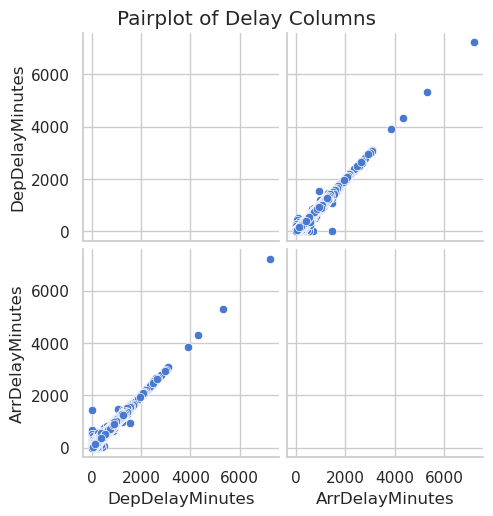

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
pdf = cleaned_flight.select(delay_columns).toPandas()

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="muted")

# Create a pairplot
# You can also add hue if you have a categorical variable to differentiate between categories
# For example: sns.pairplot(pdf, hue='YourCategoricalColumn')
pair_plot = sns.pairplot(pdf)

# Enhancing the plot
pair_plot.fig.suptitle("Pairplot of Delay Columns", y=1.02) # Add a title and adjust its position
plt.show()

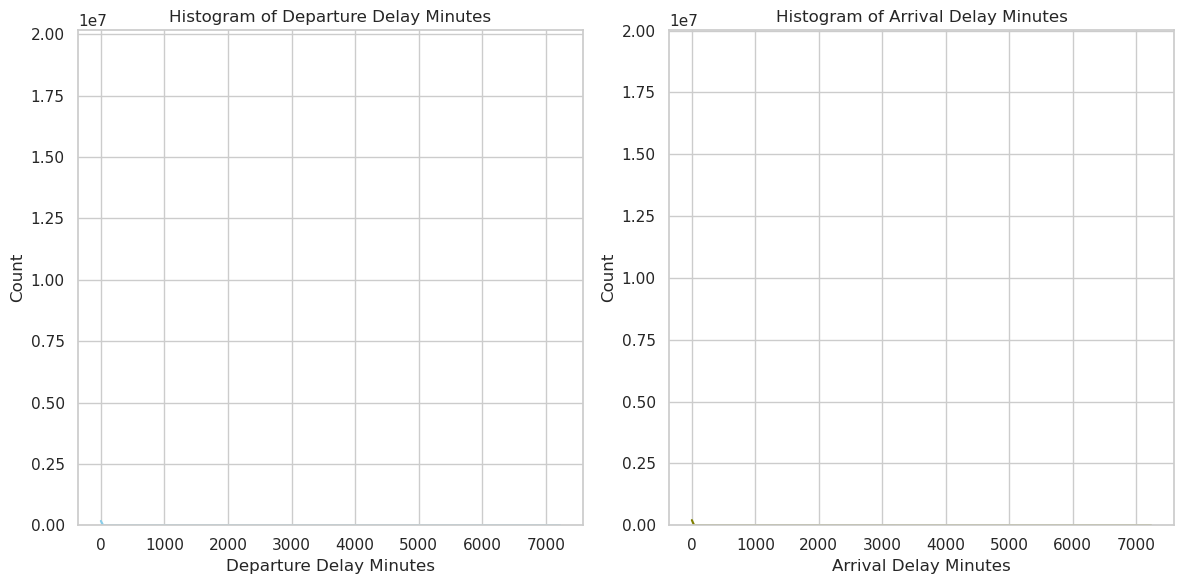

In [ ]:
# Histograms for Delay Minutes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
pdf = cleaned_flight.select('DepDelayMinutes', 'ArrDelayMinutes').toPandas()

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pdf['DepDelayMinutes'], kde=True, color="skyblue")
plt.title('Histogram of Departure Delay Minutes')
plt.xlabel('Departure Delay Minutes')

plt.subplot(1, 2, 2)
sns.histplot(pdf['ArrDelayMinutes'], kde=True, color="olive")
plt.title('Histogram of Arrival Delay Minutes')
plt.xlabel('Arrival Delay Minutes')

plt.tight_layout()
plt.show()

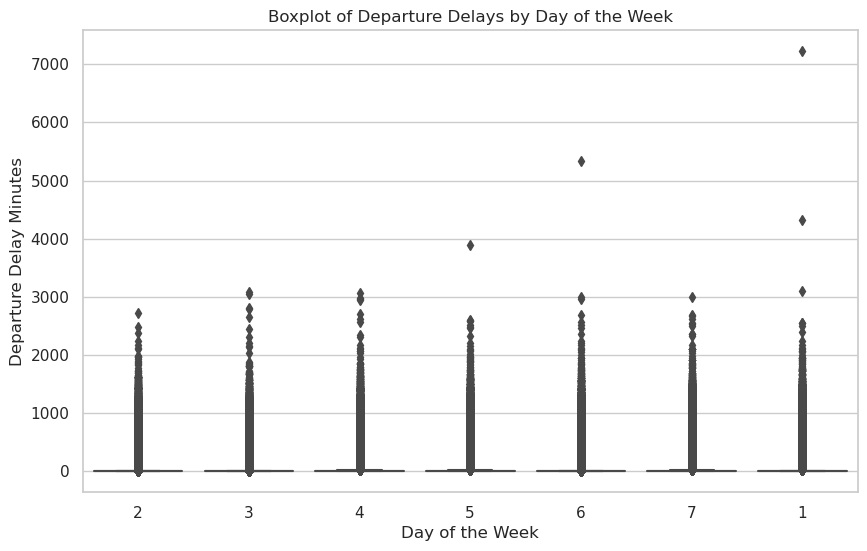

In [ ]:
# Boxplot for Delays by Day of Week

# Convert to Pandas DataFrame
pdf = cleaned_flight.select('DayOfWeek', 'DepDelayMinutes').toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='DepDelayMinutes', data=pdf)
plt.title('Boxplot of Departure Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Departure Delay Minutes')
plt.show()


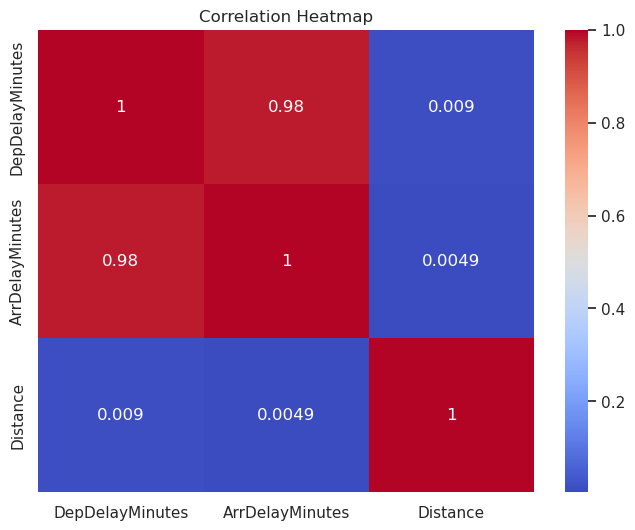

In [ ]:
# Correlation Heatmap

# Selecting numerical columns for correlation
numerical_columns = ['DepDelayMinutes', 'ArrDelayMinutes', 'Distance']
pdf = cleaned_flight.select(numerical_columns).toPandas()

# Calculating correlation matrix
corr = pdf.corr()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


##### 4. Handling Missing Values

In [12]:
# Dropping rows with missing values
df_cleaned = cleaned_flight.na.drop()

### Feature Engineering and Data Preprocessing

In [14]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# StringIndexer for categorical column
indexer = StringIndexer(inputCol='Operating_Airline', outputCol='Operating_Airline_Index')
df_indexed = indexer.fit(df_cleaned).transform(df_cleaned)

# OneHotEncoder for indexed column
encoder = OneHotEncoder(inputCol='Operating_Airline_Index', outputCol='Operating_Airline_Encoded')

# Fit and transform using the OneHotEncoder
encoder_model = encoder.fit(df_indexed)
df_encoded = encoder_model.transform(df_indexed)


In [15]:
# Feature Scaling

from pyspark.ml.feature import StandardScaler

# Assemble numeric columns into a single vector column
assembler = VectorAssembler(inputCols=['DepDelayMinutes', 'Distance'], outputCol='features')
df_cleaned = assembler.transform(df_cleaned)

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
df_cleaned = scaler.fit(df_cleaned).transform(df_cleaned)


In [16]:
#Feature Creation

from pyspark.sql.functions import col

# Example: Creating a new feature 'IsWeekend'
df_cleaned = df_cleaned.withColumn('IsWeekend', (col('DayOfWeek') > 5).cast('integer'))

In [17]:
# Feature Selection

# Selecting features to include in the model
selected_columns = ['DepDelayMinutes', 'Distance', 'IsWeekend', 'ArrDel15']
df_model = df_cleaned.select(selected_columns)

In [18]:
# Inspect DataFrame schema
df_cleaned.printSchema()

# Assuming 'Operating_Airline_Encoded' exists, select the columns
selected_columns = ['DepDelayMinutes', 'Distance', 'IsWeekend', 'ArrDel15']
df_model = df_cleaned.select(selected_columns)

root
 |-- Year: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepTimeBlk: string (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- ArrTimeBlk: string (nullable = true)
 |-- Distance: doub

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Assuming df_original is your original DataFrame before any transformation
df_original = cleaned_flight

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Assuming 'Year', 'Quarter', and 'Month' are supposed to be integers
df_original = df_original.withColumn("Year", df_original["Year"].cast(IntegerType()))
df_original = df_original.withColumn("Quarter", df_original["Quarter"].cast(IntegerType()))
df_original = df_original.withColumn("Month", df_original["Month"].cast(IntegerType()))

# Define the stages of the pipeline
indexer = StringIndexer(inputCol='Operating_Airline', outputCol='Operating_Airline_Index')
encoder = OneHotEncoder(inputCols=['Operating_Airline_Index'], outputCols=['Operating_Airline_Encoded'])
assembler = VectorAssembler(inputCols=['Year', 'Quarter', 'Month'], outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

# Combine stages into the pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler])

# Apply the pipeline to the original DataFrame
df_transformed = pipeline.fit(df_original).transform(df_original)

### Jason Chandra Model -- PIPELINE

In [ ]:
# Inspect DataFrame schema
df_transformed.printSchema()

In [30]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Assuming df_cleaned is your DataFrame
df_transformedInput = df_transformed.withColumn("ArrDel15", col("ArrDel15").cast(DoubleType()))

# Assuming df_cleaned is your preprocessed DataFrame
# Split the data into training and test sets
train_full, test_full = df_transformedInput.randomSplit([0.7, 0.3], seed=12345)

# Take a sample of the train and test sets for smaller subsets
train_subset = train_full.sample(fraction=0.01, seed=12345)
test_subset = test_full.sample(fraction=0.01, seed=12345)

# Dropping rows with null values in the train and test sets
train_subset = train_subset.na.drop()
test_subset = test_subset.na.drop()



In [31]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [32]:
# Initialize the classifiers
rf = RandomForestClassifier(labelCol="ArrDel15", featuresCol="scaledFeatures")
gbt = GBTClassifier(labelCol="ArrDel15", featuresCol="scaledFeatures")
lr = LogisticRegression(labelCol="ArrDel15", featuresCol="scaledFeatures")

# Define parameter grids
paramGridRF = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

paramGridGBT = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

paramGridLR = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

# Initialize CrossValidator for each classifier
evaluator = BinaryClassificationEvaluator(labelCol="ArrDel15")

crossvalRF = CrossValidator(estimator=rf,
                            estimatorParamMaps=paramGridRF,
                            evaluator=evaluator,
                            numFolds=3)

crossvalGBT = CrossValidator(estimator=gbt,
                             estimatorParamMaps=paramGridGBT,
                             evaluator=evaluator,
                             numFolds=3)

crossvalLR = CrossValidator(estimator=lr,
                            estimatorParamMaps=paramGridLR,
                            evaluator=evaluator,
                            numFolds=3)


In [ ]:
# Create Pipelines
pipelineRF = Pipeline(stages=[crossvalRF])
pipelineGBT = Pipeline(stages=[crossvalGBT])
pipelineLR = Pipeline(stages=[crossvalLR])

# Fit the models
modelRF = pipelineRF.fit(train_subset)
modelGBT = pipelineGBT.fit(train_subset)
modelLR = pipelineLR.fit(train_subset)


23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_123_163 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_123_48 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_5790_56 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_5790_58 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_6119_157 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_123_79 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_5790_92 !
23/11/26 21:09:07 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_123_84 !
23/11/26 21:09:07 WARN org.apache.

In [ ]:
# Saving the models
modelRF.bestModel.save("path_to_save_random_forest_model")
modelGBT.bestModel.save("path_to_save_gradient_boosted_tree_model")
modelLR.bestModel.save("path_to_save_logistic_regression_model")

# Evaluation Metrics
evaluator_auc = BinaryClassificationEvaluator(labelCol="ArrDel15", metricName="areaUnderROC")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="ArrDel15", metricName="f1")

# Evaluate RandomForest model
predictionsRF = modelRF.transform(test_subset)
aucRF = evaluator_auc.evaluate(predictionsRF)
f1_score_RF = evaluator_f1.evaluate(predictionsRF)
print(f"RandomForest AUC: {aucRF}")
print(f"RandomForest F1 Score: {f1_score_RF}")

# Evaluate Gradient Boosted Tree model
predictionsGBT = modelGBT.transform(test_subset)
aucGBT = evaluator_auc.evaluate(predictionsGBT)
f1_score_GBT = evaluator_f1.evaluate(predictionsGBT)
print(f"Gradient Boosted Tree AUC: {aucGBT}")
print(f"Gradient Boosted Tree F1 Score: {f1_score_GBT}")

# Evaluate Logistic Regression model
predictionsLR = modelLR.transform(test_subset)
aucLR = evaluator_auc.evaluate(predictionsLR)
f1_score_LR = evaluator_f1.evaluate(predictionsLR)
print(f"Logistic Regression AUC: {aucLR}")
print(f"Logistic Regression F1 Score: {f1_score_LR}")

In [ ]:
#######################

### Model Building

In [78]:
#1. Preparing the Data

# Splitting the data into training and test sets
train, test = df_transformed.randomSplit([0.7, 0.3])

In [80]:
from pyspark.sql.functions import col

# Example to check for null values in specific columns
for column in df_cleaned.columns:
    null_count = df_cleaned.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"Column {column} has {null_count} null values")


In [81]:
# Print the schema of the DataFrame
df_cleaned.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepTimeBlk: string (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- ArrTimeBlk: string (nullable = true)
 |-- Distance: doub

In [82]:
# Inspect the contents of the feature vector
df_cleaned.select("features").show(truncate=False)


+-------------+
|features     |
+-------------+
|[58.0,1005.0]|
|[0.0,660.0]  |
|[0.0,783.0]  |
|[0.0,807.0]  |
|[3.0,660.0]  |
|[0.0,660.0]  |
|[3.0,783.0]  |
|[5.0,687.0]  |
|[0.0,916.0]  |
|[2.0,1590.0] |
|[0.0,1472.0] |
|[0.0,961.0]  |
|[0.0,643.0]  |
|[0.0,851.0]  |
|[10.0,961.0] |
|[0.0,643.0]  |
|[0.0,851.0]  |
|[30.0,851.0] |
|[12.0,855.0] |
|[0.0,916.0]  |
+-------------+
only showing top 20 rows



In [83]:
# Use a small subset of the DataFrame
subset = df_cleaned.sample(fraction=0.1, seed=12345)

# Apply your model on this subset
# model.fit(subset) or similar code depending on your specific scenario


##### Decision Tree

In [86]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Assuming 'ArrDel15' is supposed to be a double
train = train.withColumn("ArrDel15", train["ArrDel15"].cast(DoubleType()))
test = test.withColumn("ArrDel15", test["ArrDel15"].cast(DoubleType()))

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="ArrDel15", featuresCol="scaledFeatures")

# Fit the model on the training data
dt_model = dt.fit(train)

# Make predictions on the test data
dt_predictions = dt_model.transform(test)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="ArrDel15")
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})

print(f"Decision Tree Accuracy: {dt_accuracy}")


23/11/26 02:53:04 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 11.0 in stage 403.0 (TID 6251) (hub-msca-bdp-dphub-students-jiaweixu-w-0.c.msca-bdp-student-ap.internal executor 48): scala.MatchError: [null,1.0,[1499.473202188546,0.8912127733964943,0.28935693829694464]] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$1(Predictor.scala:81)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.Traversa

Py4JJavaError: An error occurred while calling o2319.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 47 in stage 403.0 failed 10 times, most recent failure: Lost task 47.9 in stage 403.0 (TID 6447) (hub-msca-bdp-dphub-students-jiaweixu-w-0.c.msca-bdp-student-ap.internal executor 47): scala.MatchError: [null,1.0,[1499.473202188546,0.8912127733964943,0.28935693829694464]] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$1(Predictor.scala:81)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1207)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2298)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2299)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1209)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1202)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:274)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.$anonfun$train$1(DecisionTreeClassifier.scala:135)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:114)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: scala.MatchError: [null,1.0,[1499.473202188546,0.8912127733964943,0.28935693829694464]] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$1(Predictor.scala:81)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1207)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2298)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


23/11/26 02:53:43 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 41.3 in stage 403.0 (TID 6418) (hub-msca-bdp-dphub-students-jiaweixu-w-0.c.msca-bdp-student-ap.internal executor 47): TaskKilled (Stage cancelled)
23/11/26 02:53:43 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 13.4 in stage 403.0 (TID 6437) (hub-msca-bdp-dphub-students-jiaweixu-sw-lxj3.c.msca-bdp-student-ap.internal executor 44): TaskKilled (Stage cancelled)
23/11/26 02:53:43 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 5.4 in stage 403.0 (TID 6438) (hub-msca-bdp-dphub-students-jiaweixu-sw-lxj3.c.msca-bdp-student-ap.internal executor 44): TaskKilled (Stage cancelled)
23/11/26 02:53:43 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 14.4 in stage 403.0 (TID 6443) (hub-msca-bdp-dphub-students-jiaweixu-sw-lxj3.c.msca-bdp-student-ap.internal executor 44): TaskKilled (Stage cancelled)
23/11/26 02:53:43 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 7.4 in stage 403.0 (T

##### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol="ArrDel15", featuresCol="scaledFeatures")

# Fit the model on the training data
rf_model = rf.fit(train)

# Make predictions on the test data
rf_predictions = rf_model.transform(test)

# Evaluate the model
rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})

print(f"Random Forest Accuracy: {rf_accuracy}")


23/11/26 02:31:50 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 14.9 in stage 190.0 (TID 2623) (hub-msca-bdp-dphub-students-jiaweixu-w-0.c.msca-bdp-student-ap.internal executor 36): TaskKilled (Stage cancelled)
23/11/26 02:31:50 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 30.7 in stage 190.0 (TID 2596) (hub-msca-bdp-dphub-students-jiaweixu-w-1.c.msca-bdp-student-ap.internal executor 39): TaskKilled (Stage cancelled)
23/11/26 02:31:50 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 8.8 in stage 190.0 (TID 2621) (hub-msca-bdp-dphub-students-jiaweixu-w-1.c.msca-bdp-student-ap.internal executor 41): TaskKilled (Stage cancelled)
23/11/26 02:31:51 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 9.8 in stage 190.0 (TID 2599) (hub-msca-bdp-dphub-students-jiaweixu-w-1.c.msca-bdp-student-ap.internal executor 41): TaskKilled (Stage cancelled)
23/11/26 02:31:51 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 36.7 in stage 190.0 (TID 2601) (hu

##### Hyperparameter Tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Example for Decision Tree
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [20, 30, 40]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="ArrDel15"),
                          numFolds=3)

# Fit the model
cv_model = crossval.fit(train)

# Evaluate on the test set
cv_predictions = cv_model.transform(test)
cv_accuracy = evaluator.evaluate(cv_predictions, {evaluator.metricName: "accuracy"})
print(f"Cross-Validated Accuracy: {cv_accuracy}")

### Model Evaluation

##### Evaluate with Basic Metrics

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="f1")

# Evaluate Decision Tree model
dt_accuracy = evaluator_accuracy.evaluate(dt_predictions)
dt_precision = evaluator_precision.evaluate(dt_predictions)
dt_recall = evaluator_recall.evaluate(dt_predictions)
dt_f1 = evaluator_f1.evaluate(dt_predictions)

# Evaluate Random Forest model
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
rf_precision = evaluator_precision.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

print(f"Decision Tree - Accuracy: {dt_accuracy}, Precision: {dt_precision}, Recall: {dt_recall}, F1 Score: {dt_f1}")
print(f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1 Score: {rf_f1}")


##### ROC Curve and AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# ROC and AUC for Decision Tree
dt_evaluator = BinaryClassificationEvaluator(labelCol="ArrDel15")
dt_auc = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "areaUnderROC"})

# ROC and AUC for Random Forest
rf_auc = dt_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "areaUnderROC"})

print(f"Decision Tree - AUC: {dt_auc}")
print(f"Random Forest - AUC: {rf_auc}")


##### Confusion Matrix

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert prediction results to RDD
rdd_dt = dt_predictions.select(['prediction', 'ArrDel15']).rdd
rdd_rf = rf_predictions.select(['prediction', 'ArrDel15']).rdd

# Instantiate metrics object
metrics_dt = MulticlassMetrics(rdd_dt)
metrics_rf = MulticlassMetrics(rdd_rf)

# Confusion matrix
print("Decision Tree - Confusion Matrix")
print(metrics_dt.confusionMatrix().toArray())

print("\nRandom Forest - Confusion Matrix")
print(metrics_rf.confusionMatrix().toArray())
